In [1]:
# This code comes from the github repo https://github.com/matterport/Mask_RCNN under samples/nucleus
# The only changes we made were from loading up our own tumor data

# Mask R-CNN - Inspect Nucleus Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

#import nucleus
import tumor

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


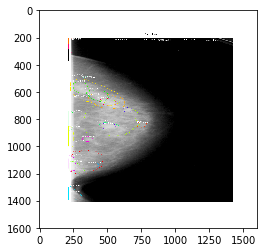

In [2]:
res = plt.imread('/home/Mask_RCNN/results/nucleus/submit_20181212T041253/100_val.png')
plt.imshow(res)
plt.show()

In [3]:
# Comment out to reload imported modules if they change
# %load_ext autoreload
# %autoreload 2

## Configurations

In [4]:
# Dataset directory
#DATASET_DIR = os.path.join(ROOT_DIR, "datasets/nucleus")
DATASET_DIR = './cbis_dataset'

# Inference Configuration
config = tumor.TumorInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

## Notebook Preferences

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Validation Dataset

In [7]:
# Load validation dataset
dataset = tumor.TumorDataset()
dataset.load_tumor(DATASET_DIR, "val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

620
Images: 620
Classes: ['BG', 'tumor']


## Load Model

In [8]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [9]:
# Path to a specific weights file
# weights_path = "/path/to/mask_rcnn_nucleus.h5"

# Or, load the last model you trained
weights_path = '/home/Mask_RCNN/logs/tumor20181211T2252/mask_rcnn_tumor_0040.h5' #model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/Mask_RCNN/logs/tumor20181211T2252/mask_rcnn_tumor_0040.h5
Re-starting from epoch 40


## Run Detection

image ID: tumor.115_val (519) 115_val
Original image shape:  [1024 1024    3]
Processing 1 images
image                    shape: (2048, 2048, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 2048, 2048, 3)    min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 1047552, 4)       min:   -0.04422  max:    1.01295  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  572.00000  max: 1190.00000  int32
gt_mask                  shape: (2048, 2048, 1)       min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.200
AP @0.55:	 0.200
AP @0.60:	 0.200
AP @0.65:	 0.200
AP @0.70:	 0.200
AP @0.75:	 0.200
AP @0.80:	 0.200
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0.50-0.95:	 0.140


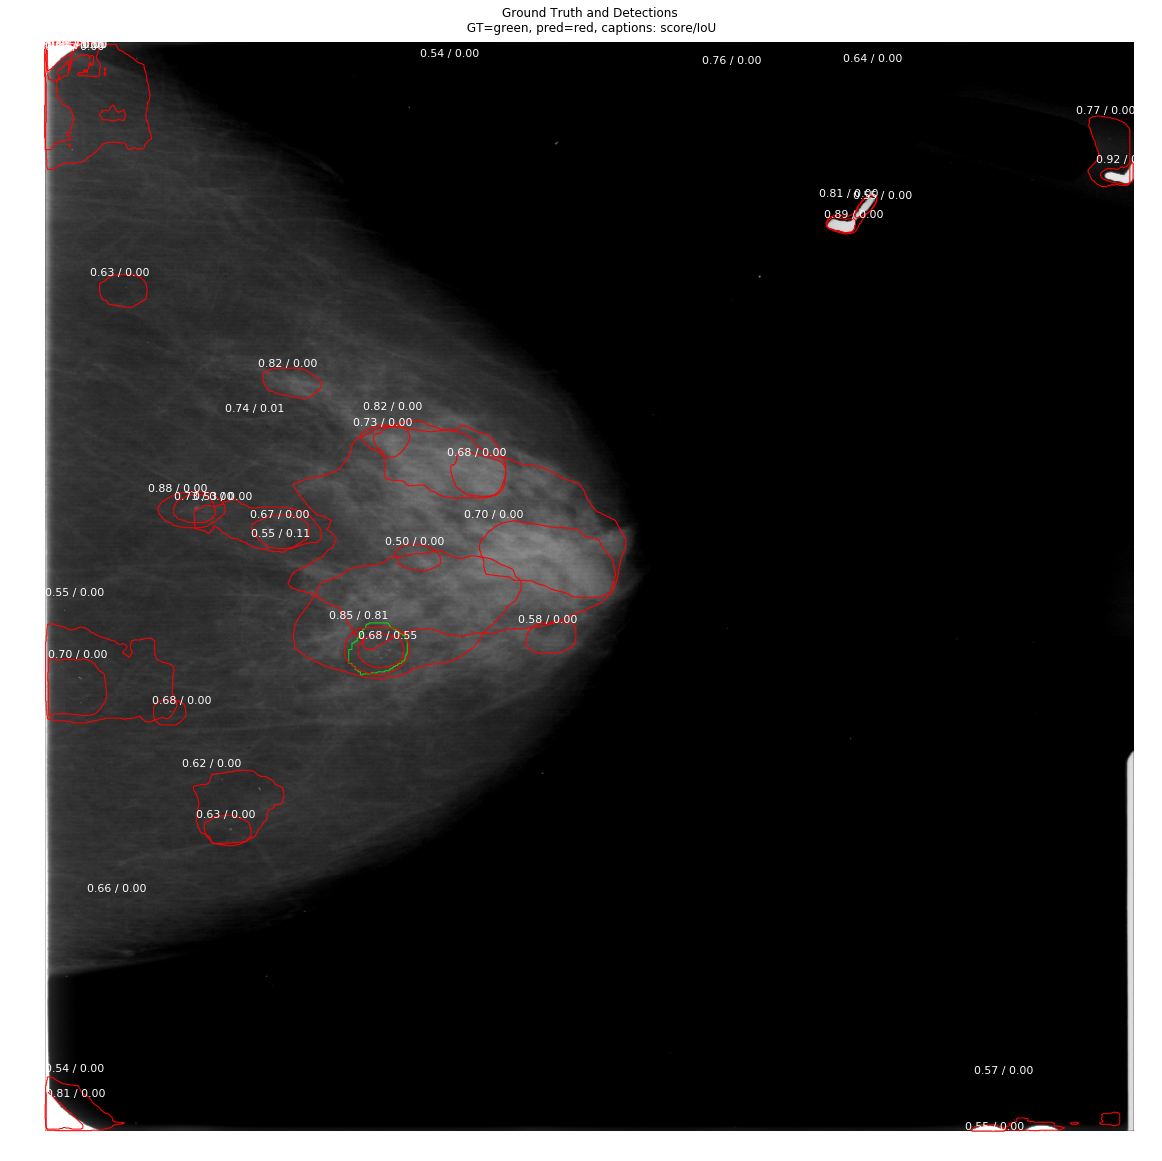

In [36]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

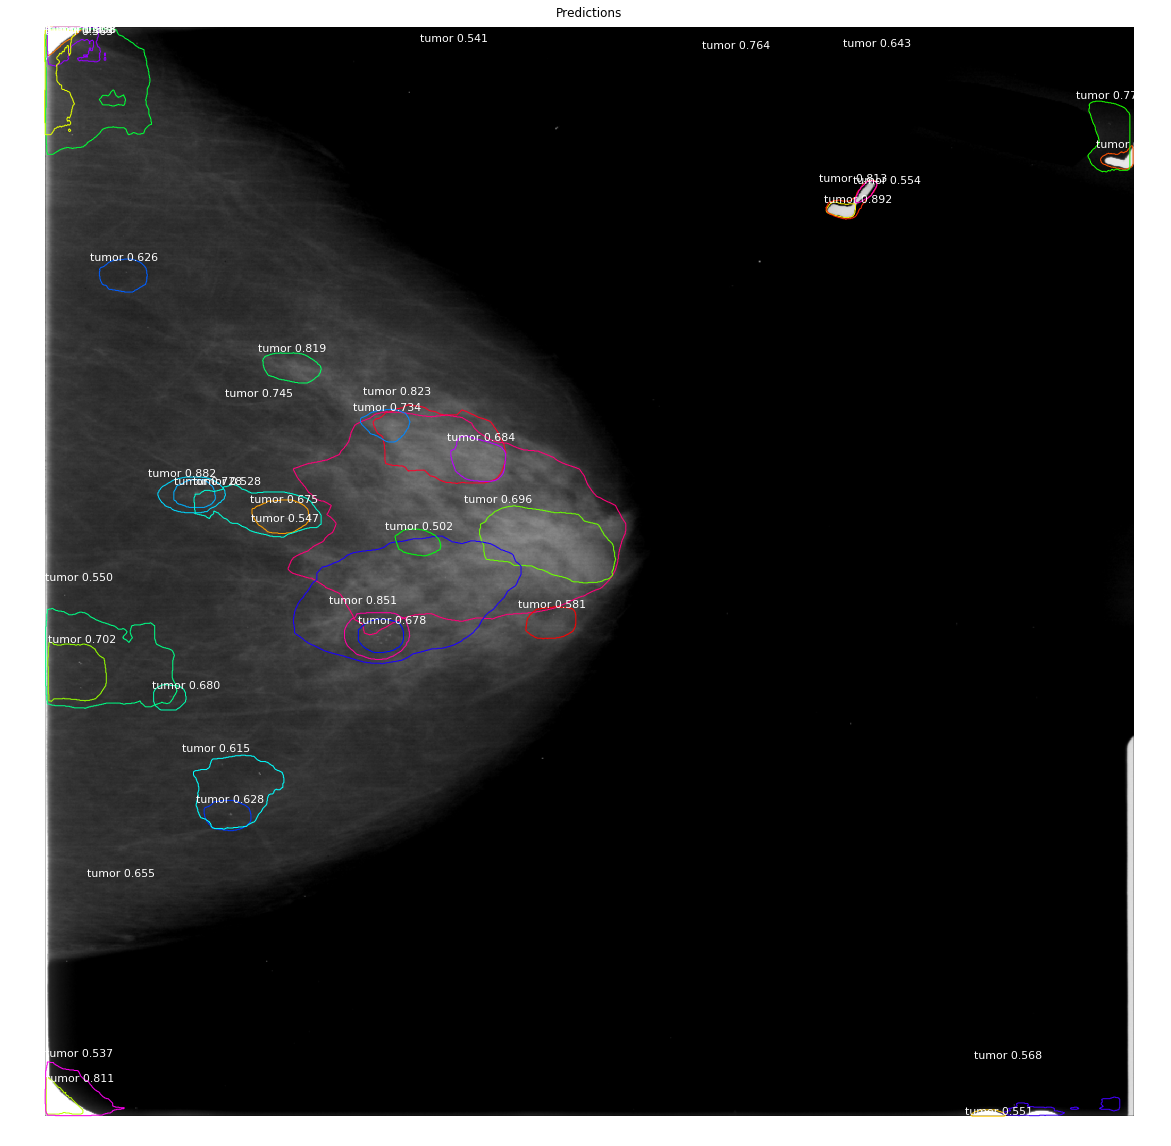

In [37]:
# Display predictions only
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=get_ax(1),
                            show_bbox=False, show_mask=False,
                            title="Predictions")

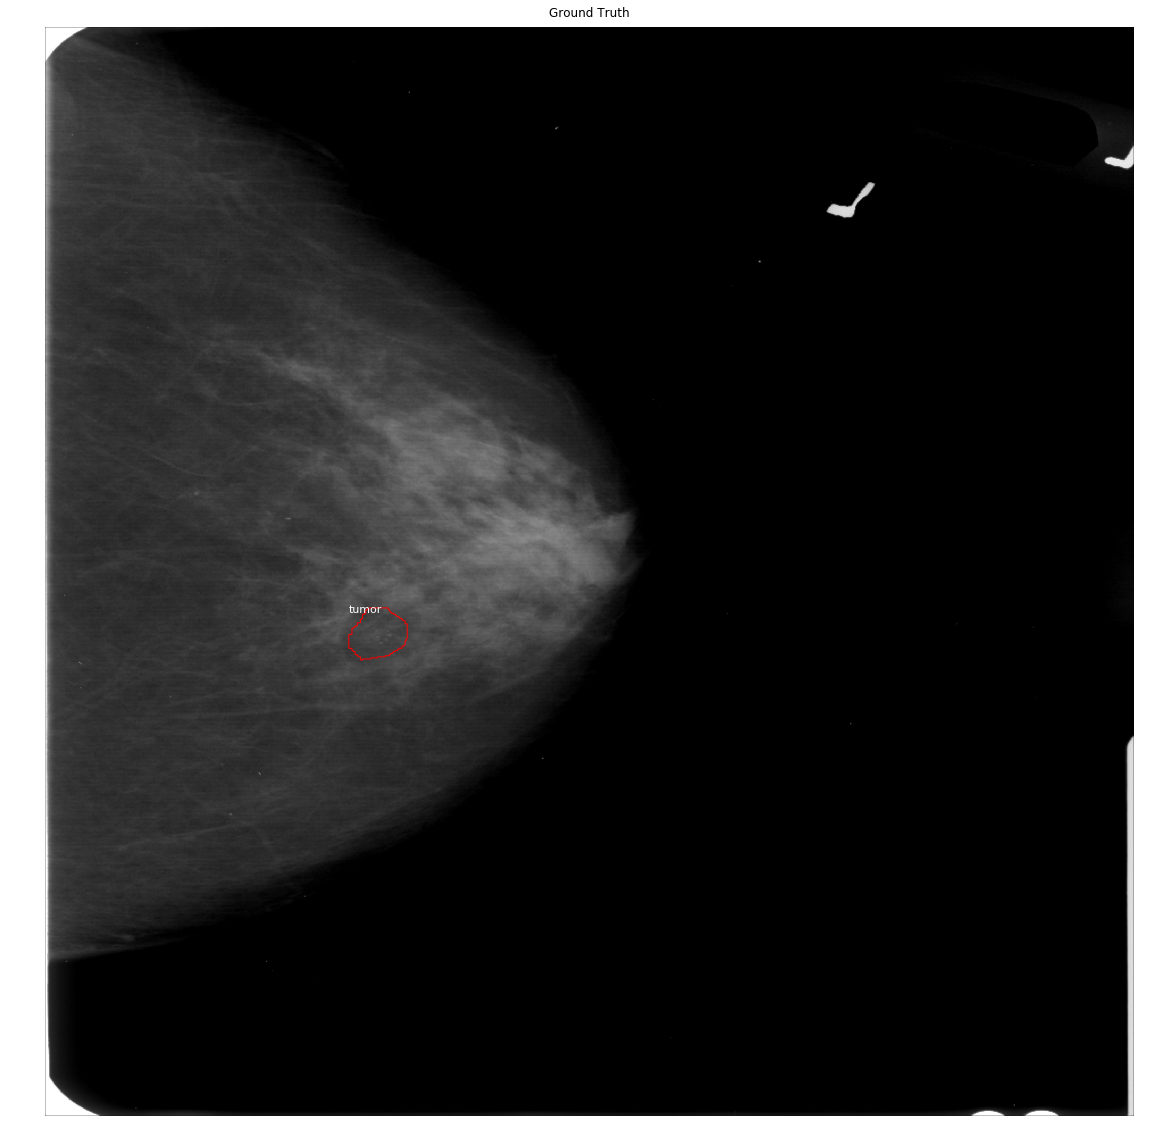

In [38]:
# Display Ground Truth only
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, ax=get_ax(1),
                            show_bbox=False, show_mask=False,
                            title="Ground Truth")

### Compute AP on Batch of Images

In [11]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set
limit = 50
APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [1024 1024    3]   AP: 0.00
  1 [1024 1024    3]   AP: 0.80
  2 [1024 1024    3]   AP: 0.00
  3 [1024 1024    3]   AP: 0.70
  4 [1024 1024    3]   AP: 0.13
  5 [1024 1024    3]   AP: 0.00
 10 [1024 1024    3]   AP: 0.00
 11 [1024 1024    3]   AP: 0.02
 12 [1024 1024    3]   AP: 0.00
 13 [1024 1024    3]   AP: 0.00
 14 [1024 1024    3]   AP: 0.00
 15 [1024 1024    3]   AP: 0.00
 16 [1024 1024    3]   AP: 0.00
 17 [1024 1024    3]   AP: 0.25
 18 [1024 1024    3]   AP: 0.03
 19 [1024 1024    3]   AP: 0.00
 20 [1024 1024    3]   AP: 0.06
 21 [1024 1024    3]   AP: 0.60
 22 [1024 1024    3]   AP: 0.00
 23 [1024 1024    3]   AP: 0.00
 24 [1024 1024    3]   AP: 0.00
 25 [1024 1024    3]   AP: 0.00
 26 [1024 1024    3]   AP: 0.01
 27 [1024 1024    3]   AP: 0.00
 28 [1024 1024    3]   AP: 0.00
 29 [1024 1024    3]   AP: 0.00
 30 [1024 1024    3]   AP: 0.00
 31 [1024 1024    3]   AP: 0.00
 32 [1024 1024    3]   AP: 0.60
 33 [1024 1024    3]   AP: 0.06
 34 [1024 1024    3]   AP: 0.00
 35 [102

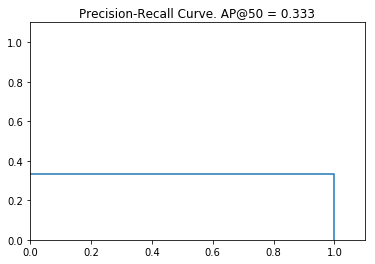

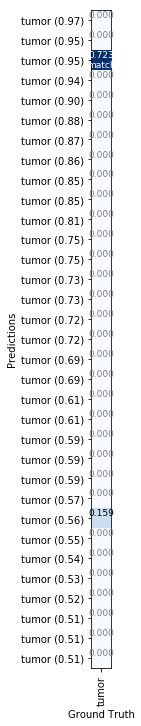

In [21]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

In [19]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.0


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [27]:
# Get anchors and convert to pixel coordinates
anchors = model.get_anchors(image.shape)
anchors = utils.denorm_boxes(anchors, image.shape[:2])
log("anchors", anchors)

# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = anchors[positive_anchor_ix]
negative_anchors = anchors[negative_anchor_ix]
neutral_anchors = anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

anchors                  shape: (1047552, 4)          min:  -91.00000  max: 2075.00000  int32
target_rpn_match         shape: (1047552,)            min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (64, 4)               min:   -1.64062  max:   13.35938  float64
positive_anchors         shape: (1, 4)                min:  576.00000  max: 1024.00000  int32
negative_anchors         shape: (63, 4)               min:  -23.00000  max: 2031.00000  int32
neutral anchors          shape: (1047488, 4)          min:  -91.00000  max: 2075.00000  int32
refined_anchors          shape: (1, 4)                min:  540.00000  max: 1082.00000  float32


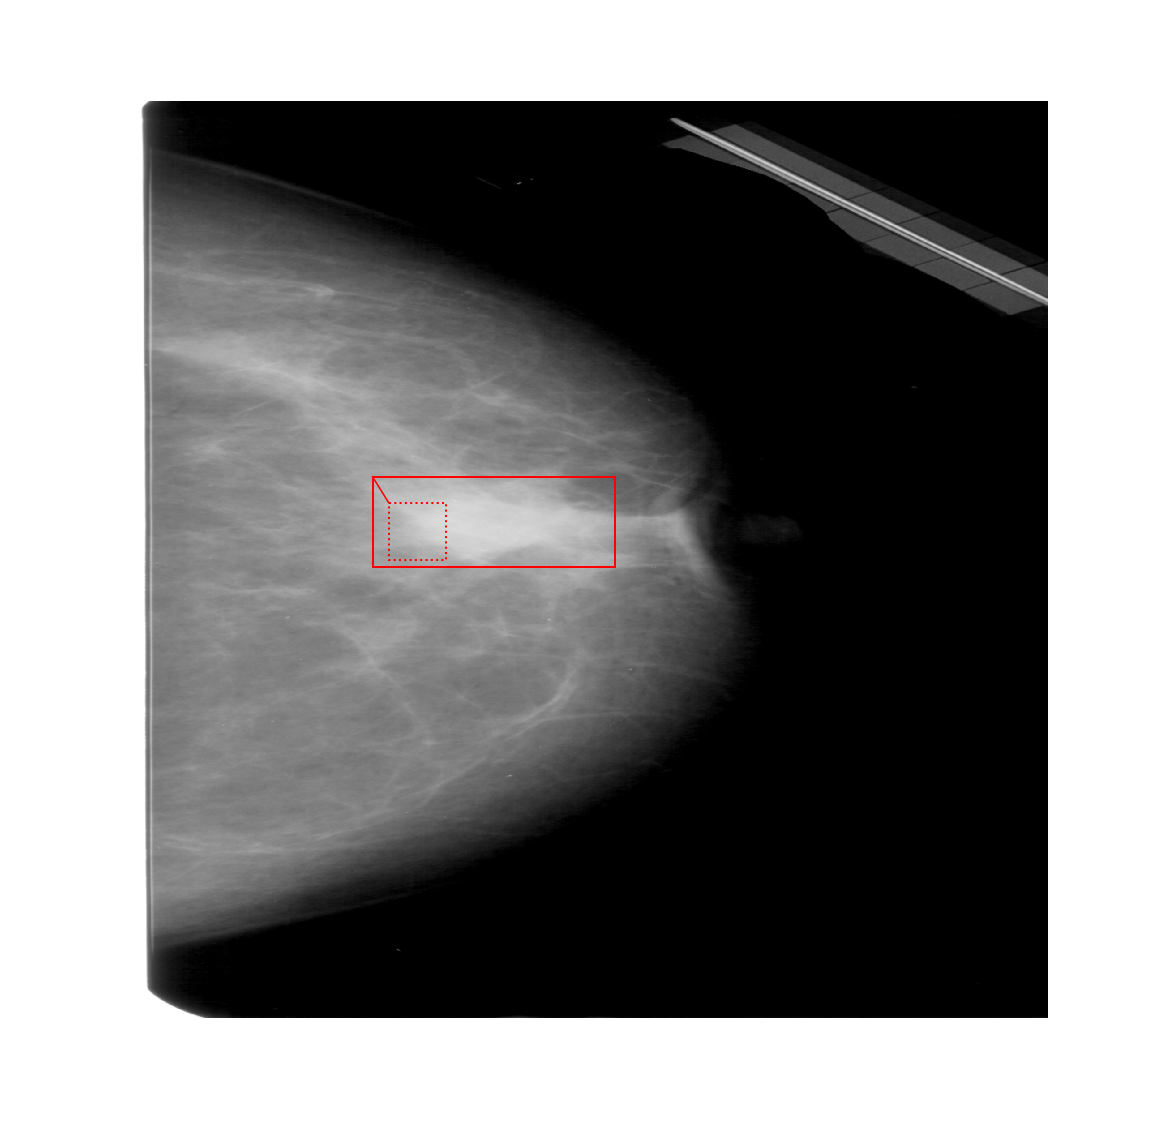

In [28]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=positive_anchors,
    refined_boxes=refined_anchors)

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [29]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph(image[np.newaxis], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
], image_metas=image_meta[np.newaxis])

rpn_class                shape: (1, 1047552, 2)       min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.04422  max:    1.01295  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.54844  max:    1.18054  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (2000,)               min:    0.00000  max: 2296.00000  int32
proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


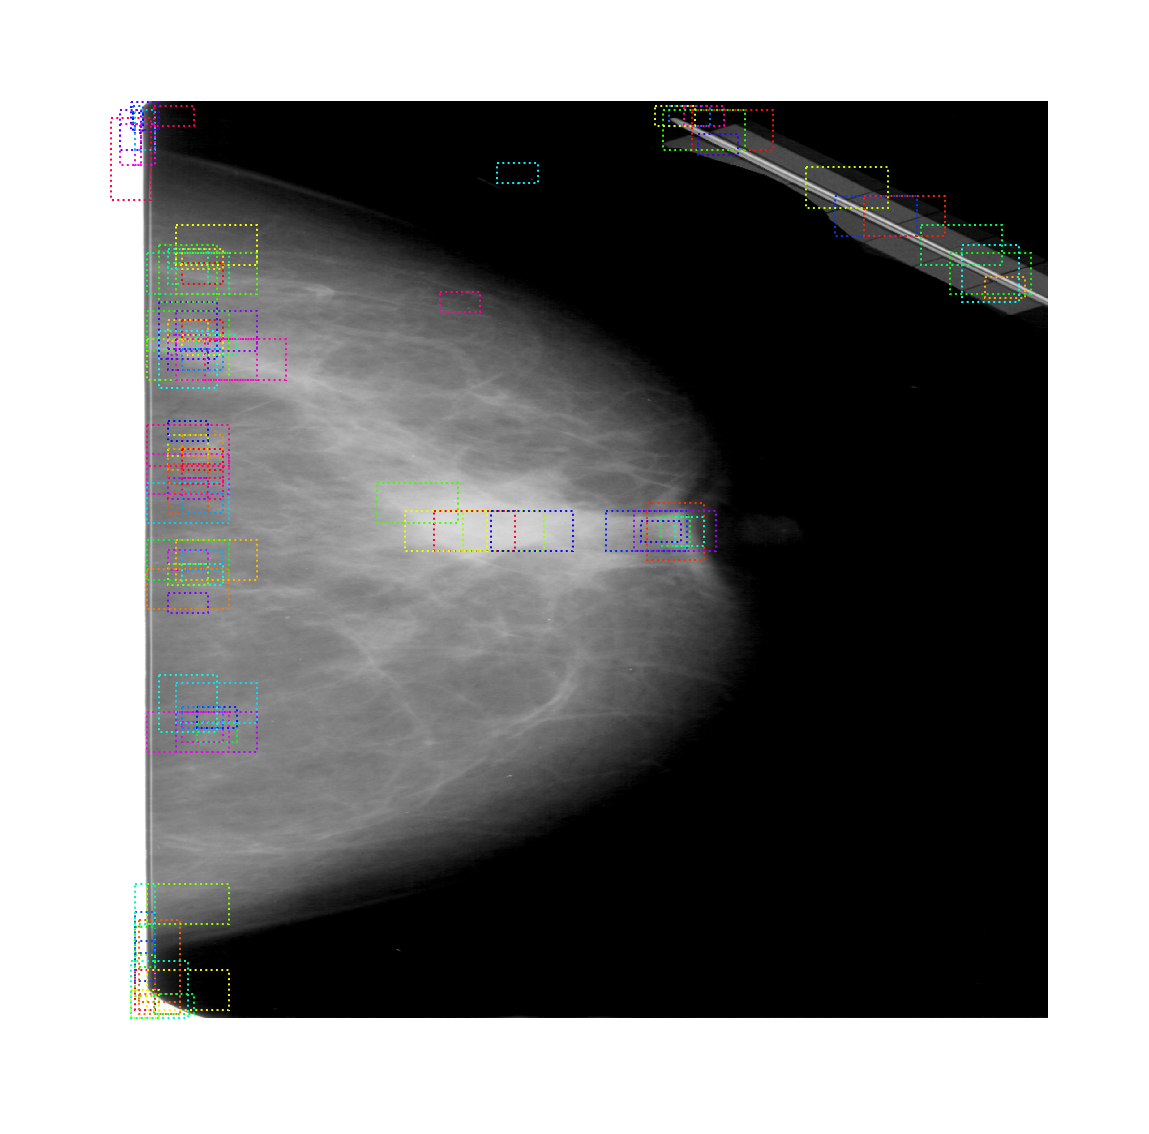

In [31]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=anchors[sorted_anchor_ids[:limit]], ax=get_ax())

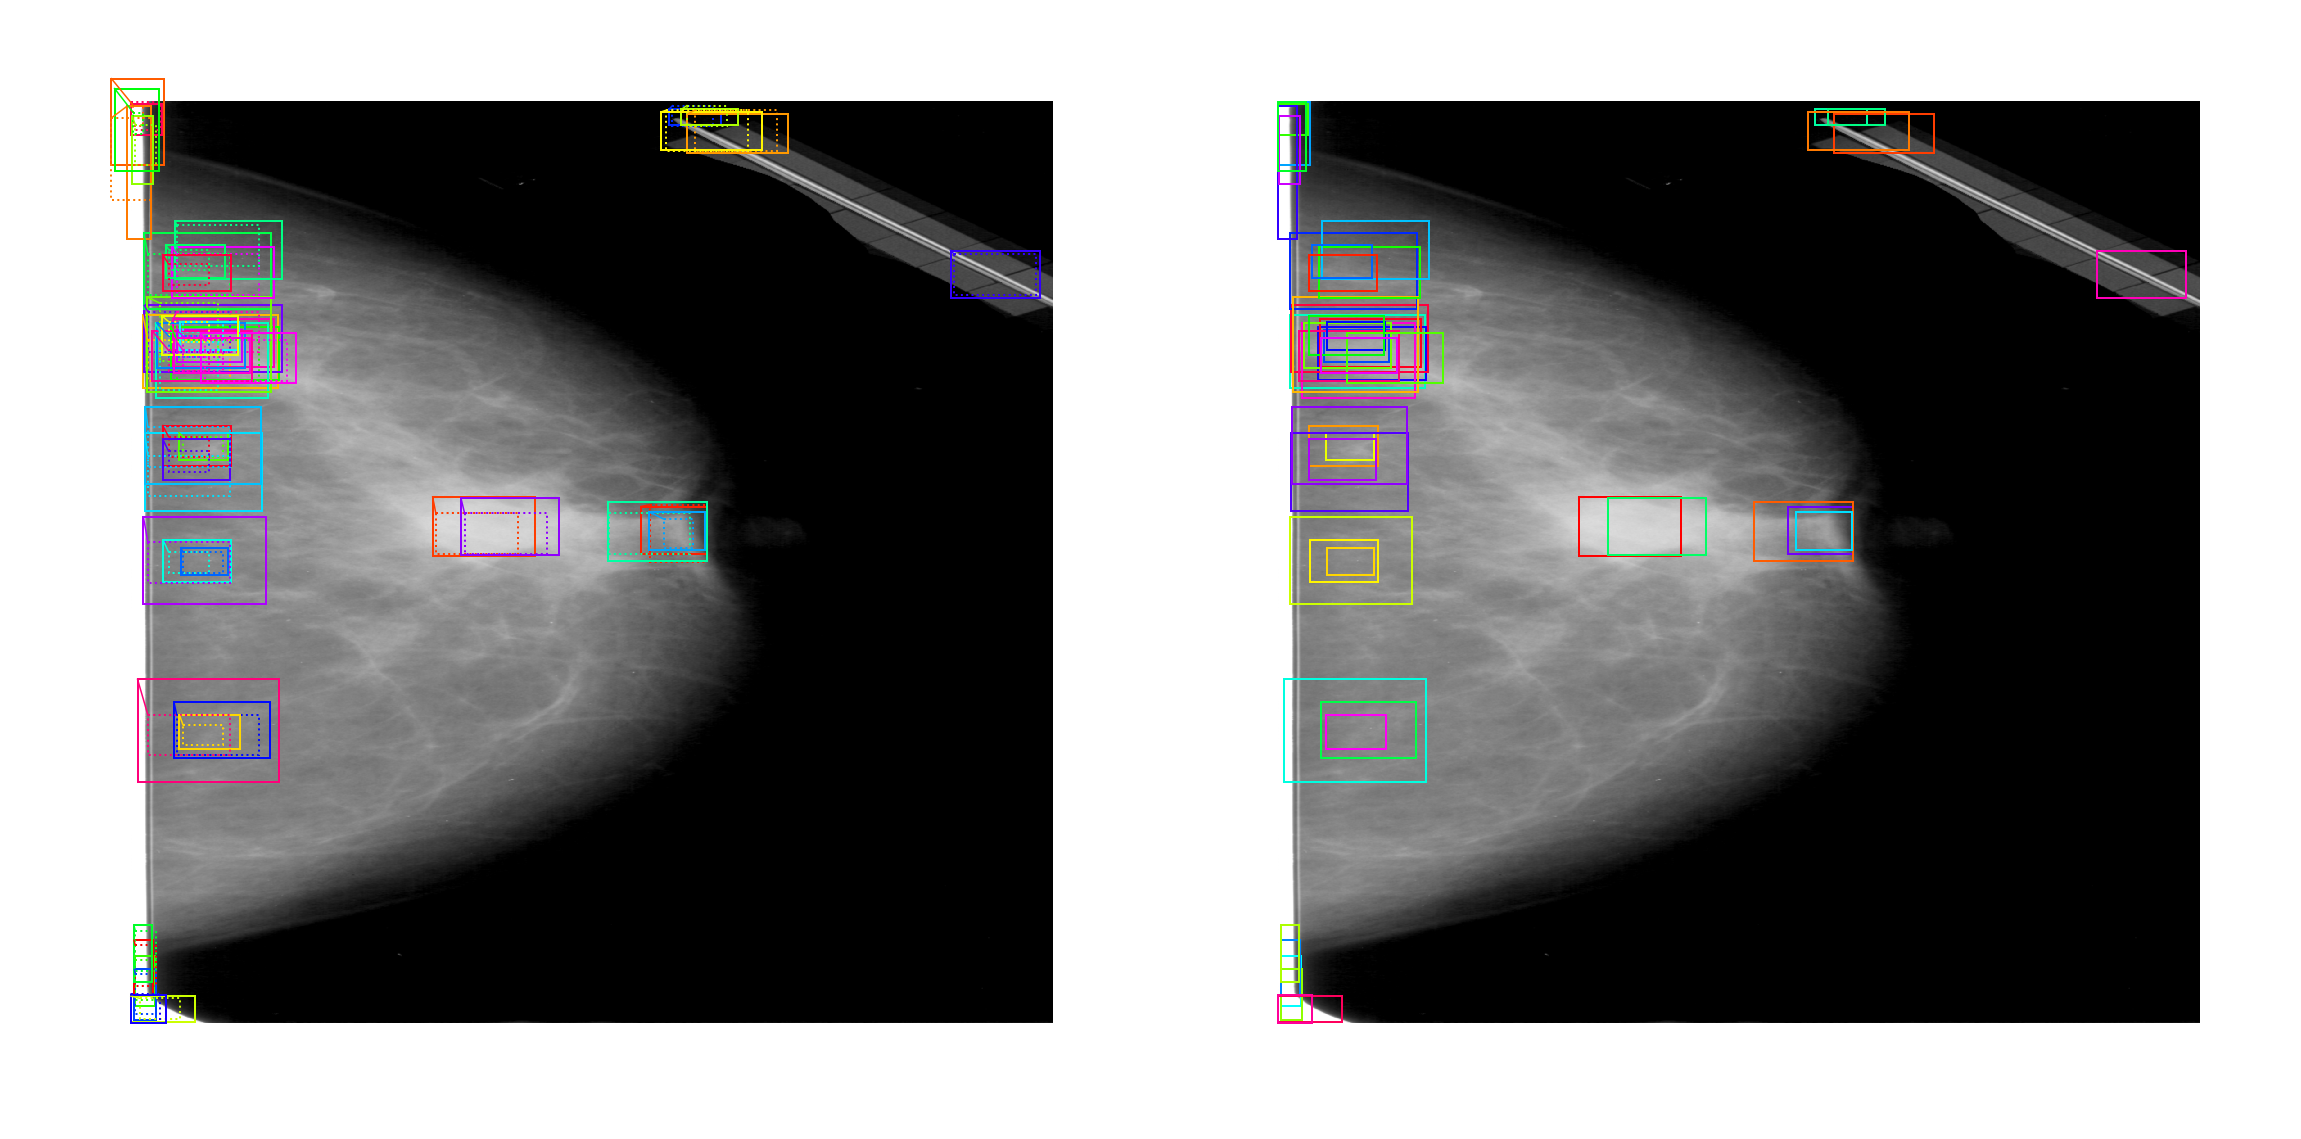

In [33]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

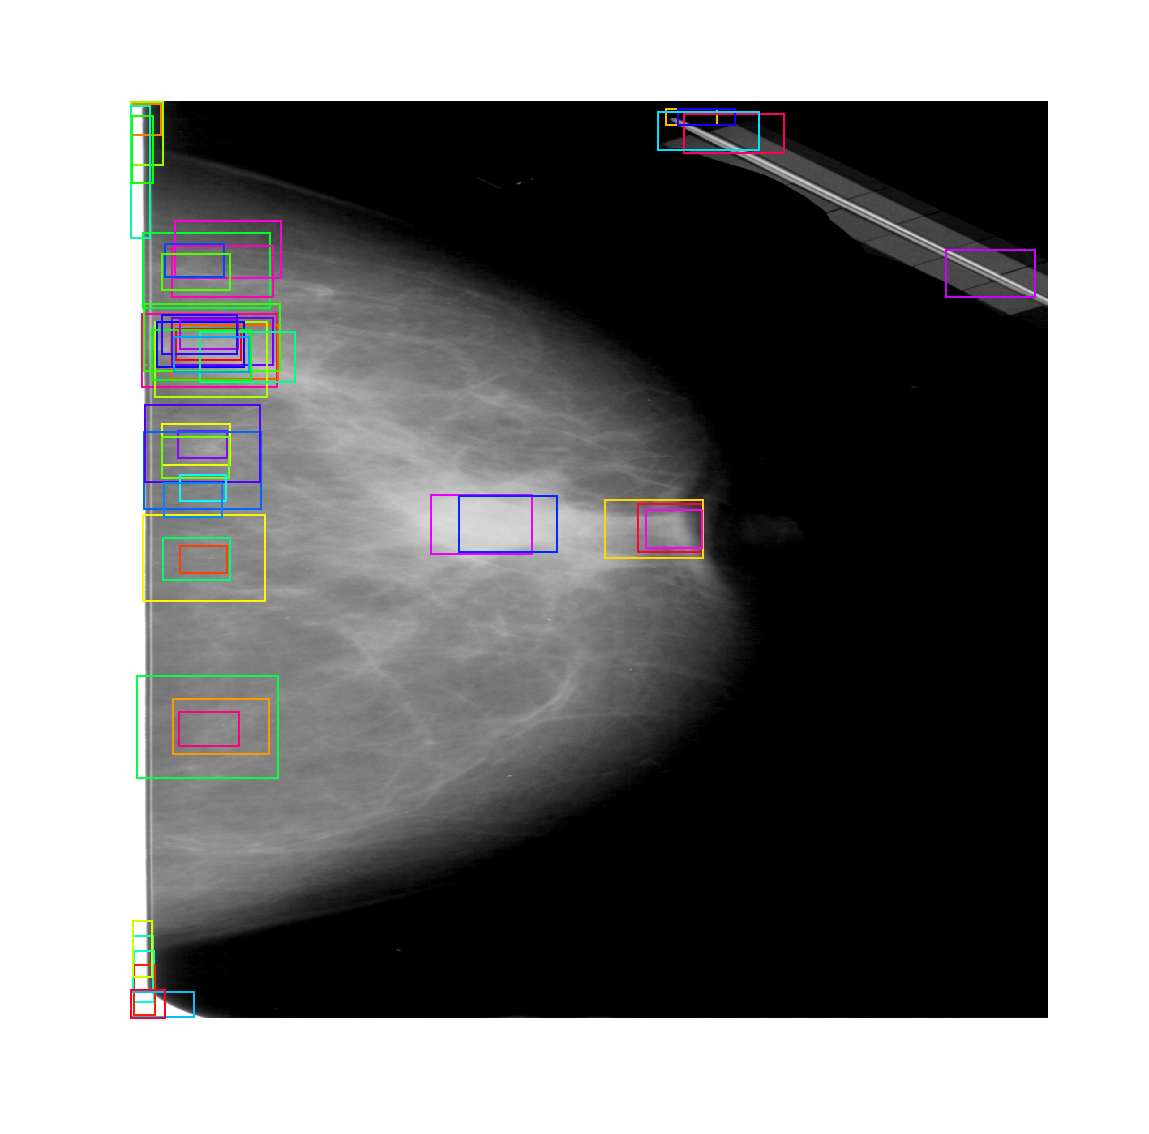

In [34]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

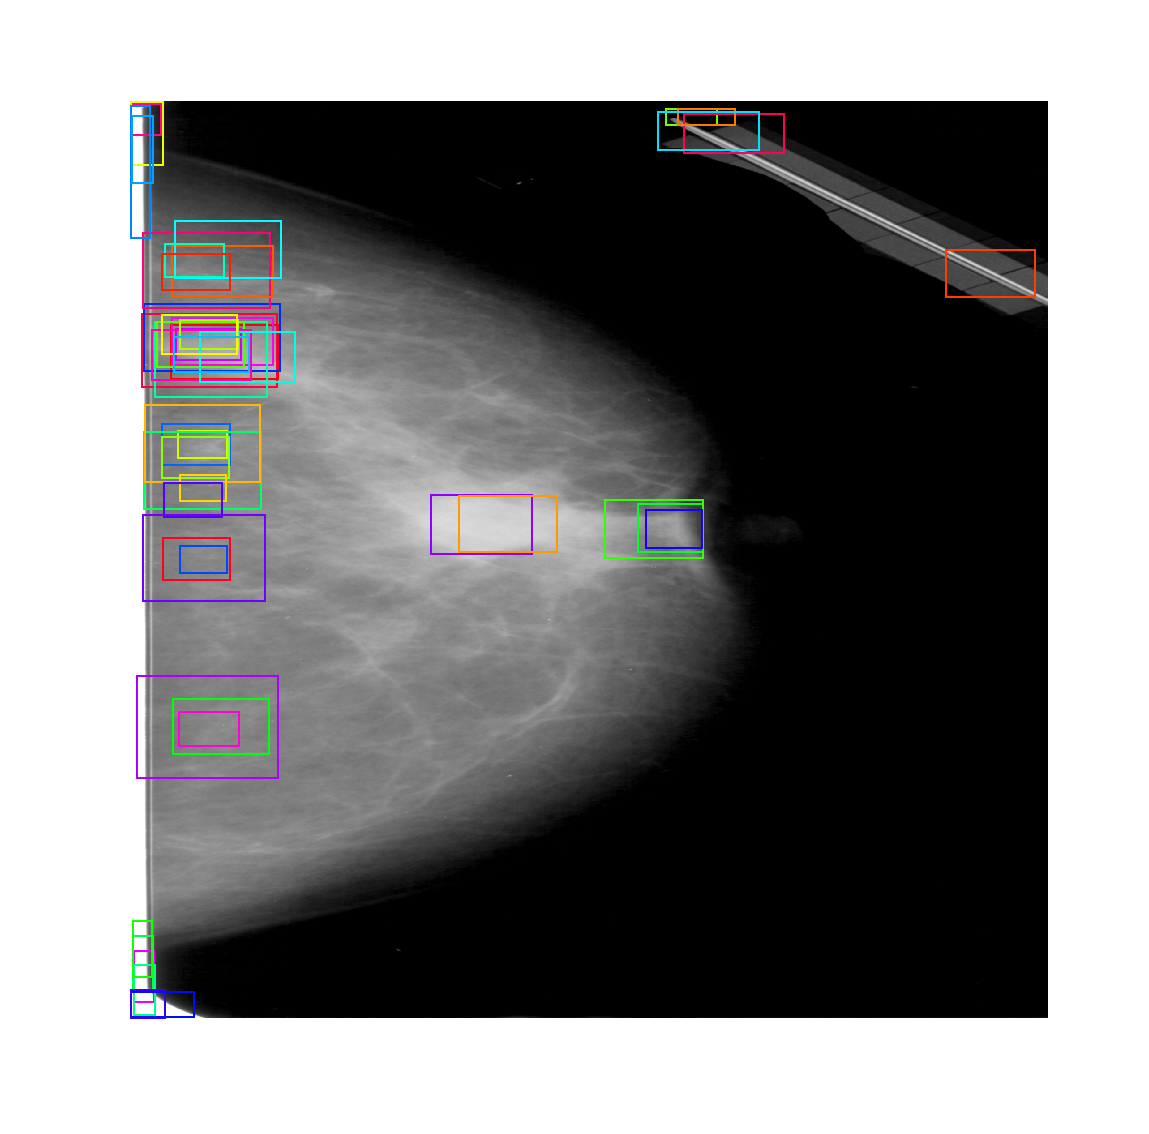

In [35]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
# h, w = config.IMAGE_SHAPE[:2]
# proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(
    image, ax=get_ax(),
    refined_boxes=utils.denorm_boxes(rpn['proposals'][0, :limit], image.shape[:2]))

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [36]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 2000, 2)          min:    0.00154  max:    0.99846  float32
deltas                   shape: (1, 2000, 2, 4)       min:   -2.49202  max:    2.38754  float32
masks                    shape: (1, 400, 28, 28, 2)   min:    0.00397  max:    0.99763  float32
detections               shape: (1, 400, 6)           min:    0.00000  max:    1.00000  float32


45 detections: ['tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor']


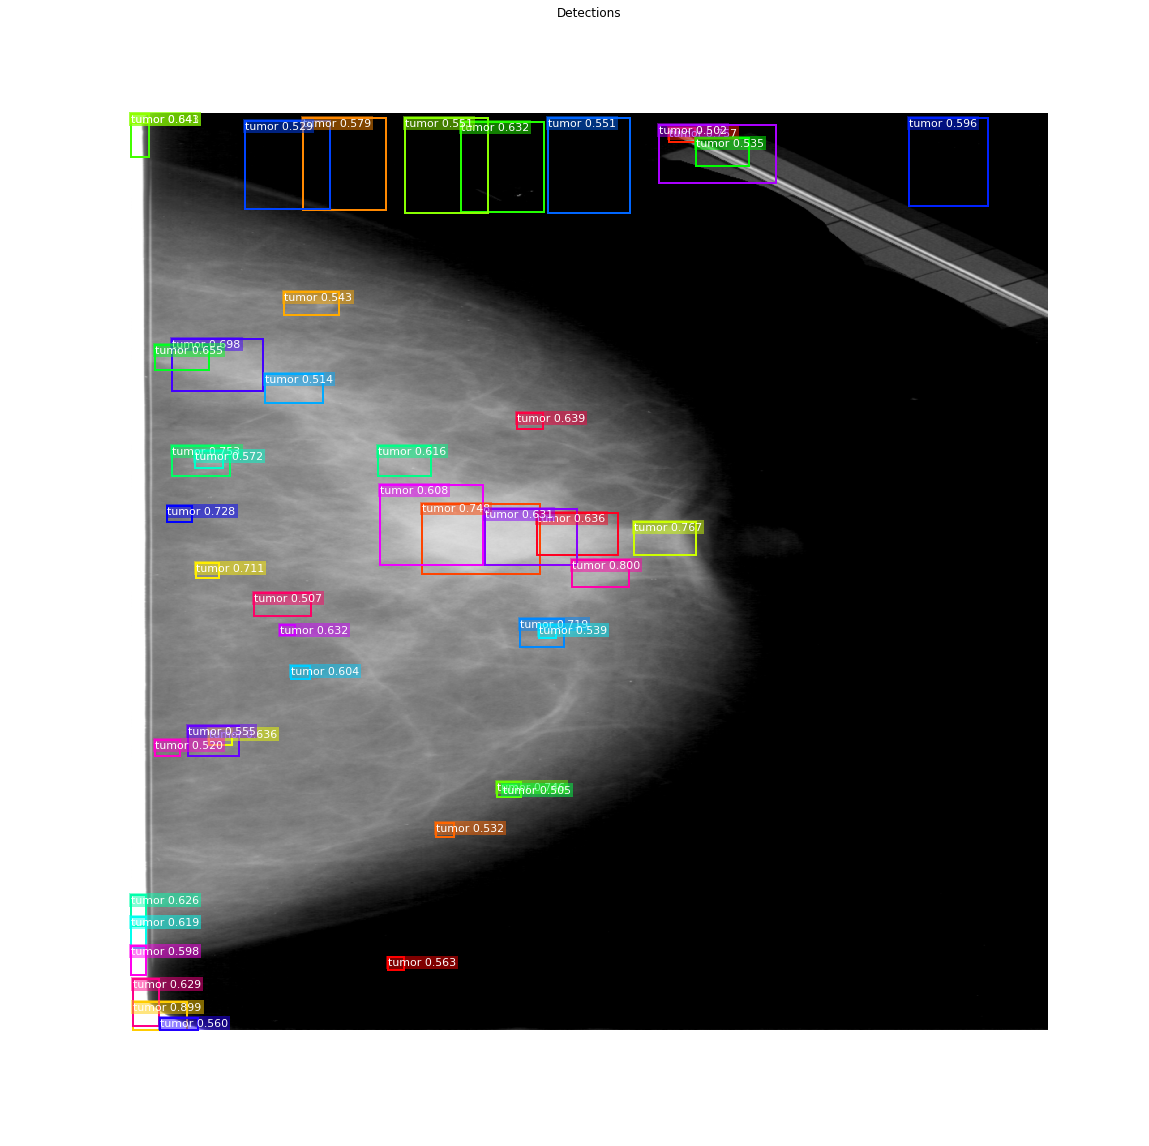

In [37]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [38]:
# Proposals are in normalized coordinates
proposals = mrcnn["proposals"][0]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

2000 Valid proposals out of 2000
179 Positive ROIs
[('BG', 1821), ('tumor', 179)]


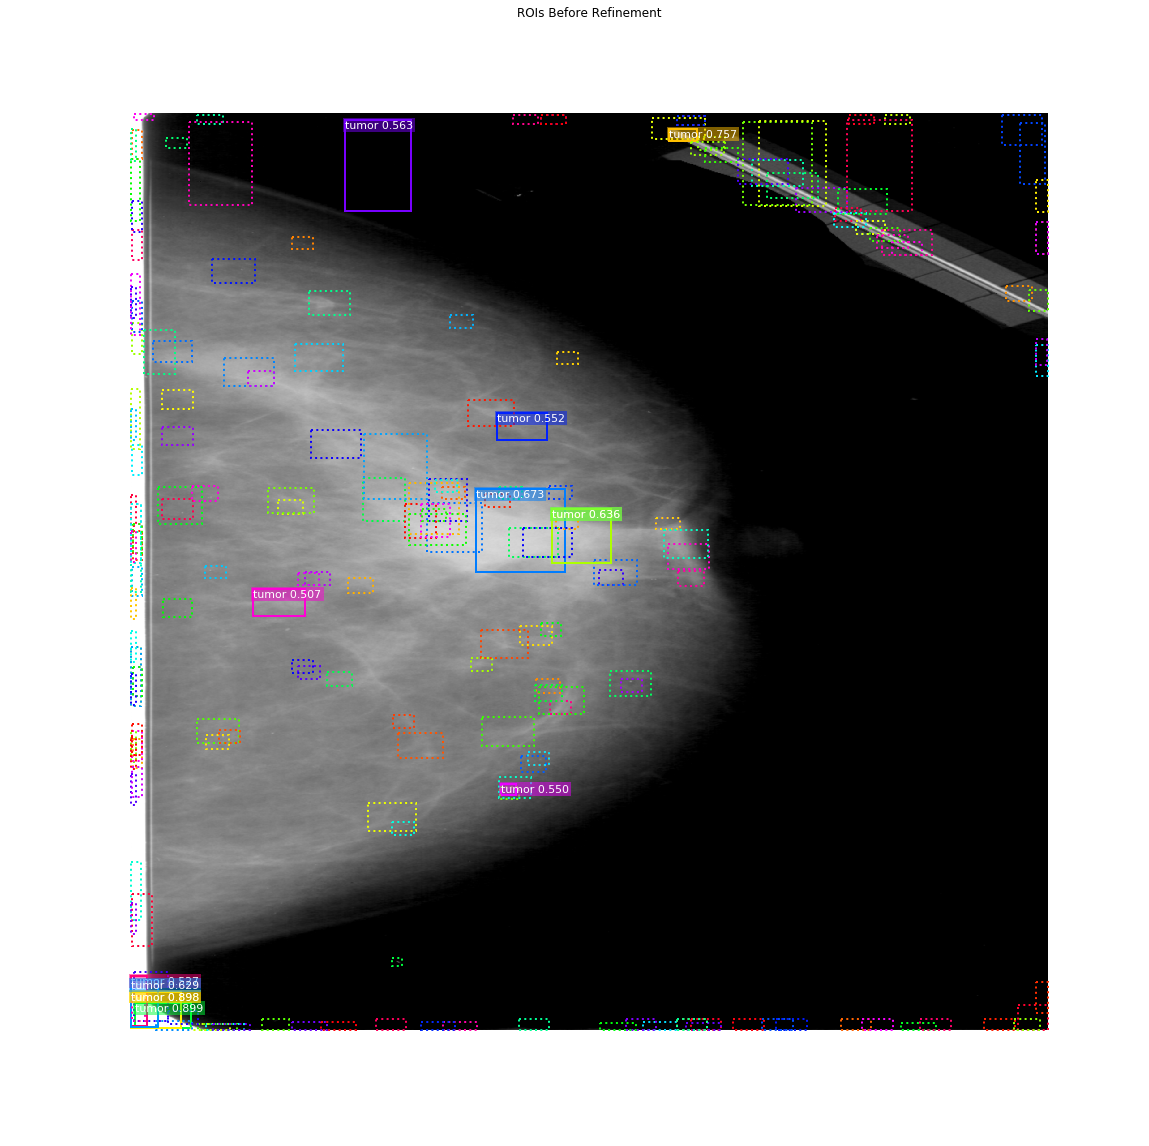

In [39]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
    captions=captions, title="ROIs Before Refinement",
    ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (2000, 4)             min:   -2.16267  max:    2.01757  float32
refined_proposals        shape: (2000, 4)             min:   -0.00509  max:    1.00183  float32


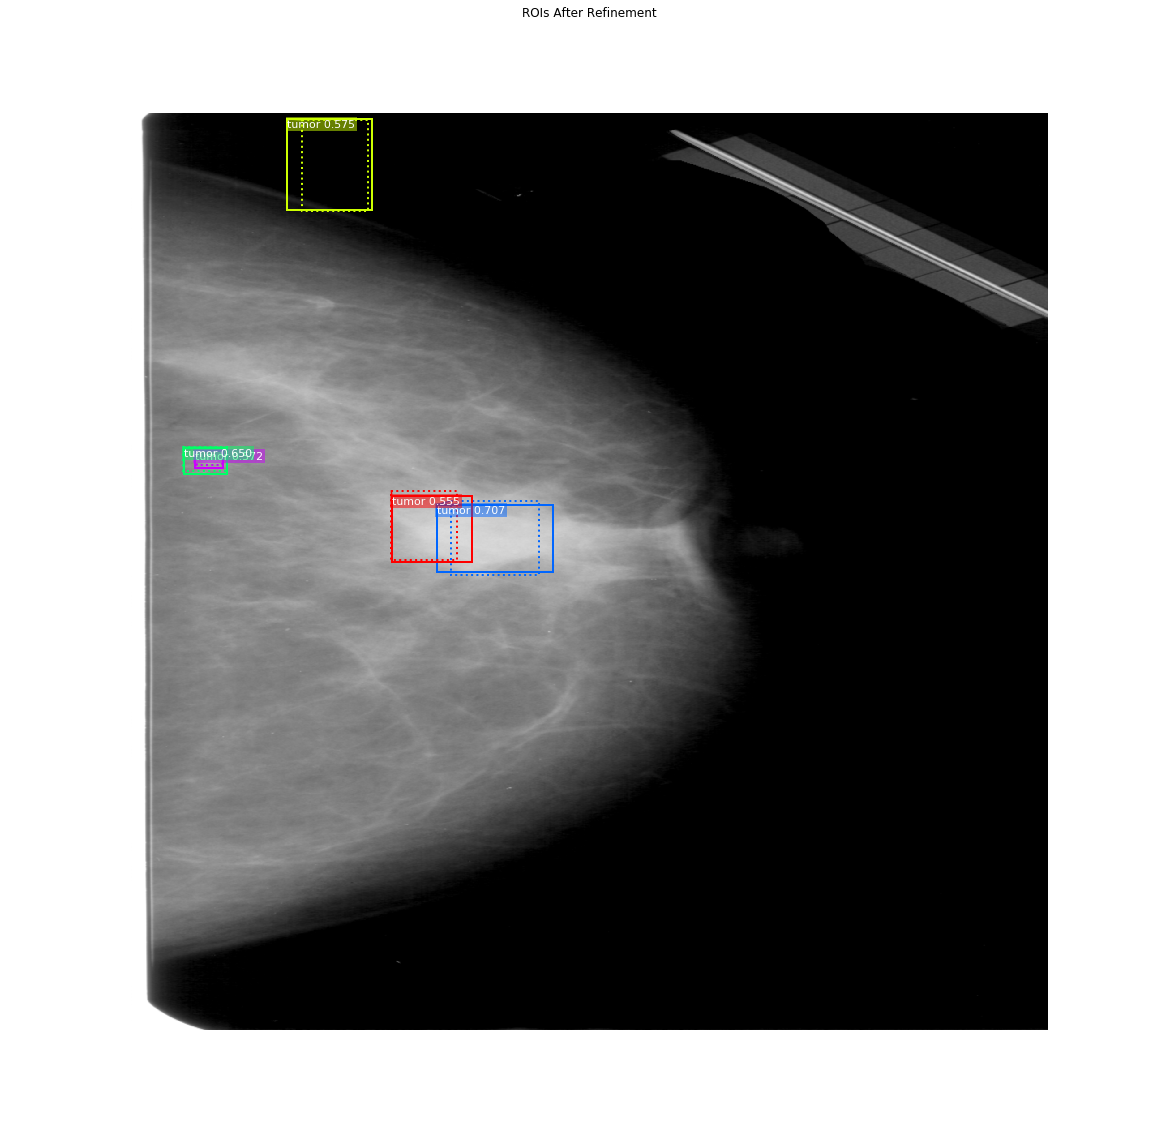

In [44]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV)
log("refined_proposals", refined_proposals)

# Show positive proposals
#ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(
    image, ax=get_ax(),
    boxes=utils.denorm_boxes(proposals[roi_positive_ixs][ids], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[roi_positive_ixs][ids], image.shape[:2]),
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="ROIs After Refinement")

#### Filter Low Confidence Detections

In [45]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 179 detections:
[   2    3    5    6    8    9   10   12   13   14   15   16   20   24
   27   29   34   35   37   38   39   40   41   42   43   44   45   50
   56   57   58   60   61   64   66   68   73   78   80   91   92  100
  102  106  109  110  111  112  113  115  116  117  118  119  120  121
  122  123  124  125  126  127  129  130  131  135  138  139  151  157
  174  189  202  204  214  220  233  258  264  267  271  310  345  348
  353  393  409  416  426  441  453  461  465  469  470  473  512  514
  518  528  538  559  572  585  611  616  618  621  637  638  645  653
  679  691  716  774  780  794  813  822  827  911  917  920  933  949
  965 1053 1062 1108 1116 1160 1163 1172 1174 1177 1209 1211 1217 1260
 1266 1283 1286 1290 1316 1323 1331 1332 1335 1354 1368 1378 1387 1394
 1397 1414 1417 1436 1464 1489 1495 1508 1625 1636 1675 1689 1694 1704
 1705 1723 1749 1785 1797 1826 1952 1961 1973 1992 1997]


In [46]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0 confidence. Keep 179:
[   2    3    5    6    8    9   10   12   13   14   15   16   20   24
   27   29   34   35   37   38   39   40   41   42   43   44   45   50
   56   57   58   60   61   64   66   68   73   78   80   91   92  100
  102  106  109  110  111  112  113  115  116  117  118  119  120  121
  122  123  124  125  126  127  129  130  131  135  138  139  151  157
  174  189  202  204  214  220  233  258  264  267  271  310  345  348
  353  393  409  416  426  441  453  461  465  469  470  473  512  514
  518  528  538  559  572  585  611  616  618  621  637  638  645  653
  679  691  716  774  780  794  813  822  827  911  917  920  933  949
  965 1053 1062 1108 1116 1160 1163 1172 1174 1177 1209 1211 1217 1260
 1266 1283 1286 1290 1316 1323 1331 1332 1335 1354 1368 1378 1387 1394
 1397 1414 1417 1436 1464 1489 1495 1508 1625 1636 1675 1689 1694 1704
 1705 1723 1749 1785 1797 1826 1952 1961 1973 1992 1997]


#### Per-Class Non-Max Suppression

In [47]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

tumor                 : [   2    3    5    6    8    9   10   12   13   14   15   16   20   24
   27   29   34   35   37   38   39   40   41   42   43   44   45   50
   56   57   58   60   61   64   66   68   73   78   80   91   92  100
  102  106  109  110  111  112  113  115  116  117  118  119  120  121
  122  123  124  125  126  127  129  130  131  135  138  139  151  157
  174  189  202  204  214  220  233  258  264  267  271  310  345  348
  353  393  409  416  426  441  453  461  465  469  470  473  512  514
  518  528  538  559  572  585  611  616  618  621  637  638  645  653
  679  691  716  774  780  794  813  822  827  911  917  920  933  949
  965 1053 1062 1108 1116 1160 1163 1172 1174 1177 1209 1211 1217 1260
 1266 1283 1286 1290 1316 1323 1331 1332 1335 1354 1368 1378 1387 1394
 1397 1414 1417 1436 1464 1489 1495 1508 1625 1636 1675 1689 1694 1704
 1705 1723 1749 1785 1797 1826 1952 1961 1973 1992 1997] -> [   3   61 1436  135   38  716  518 1705   13  204   68 1625    

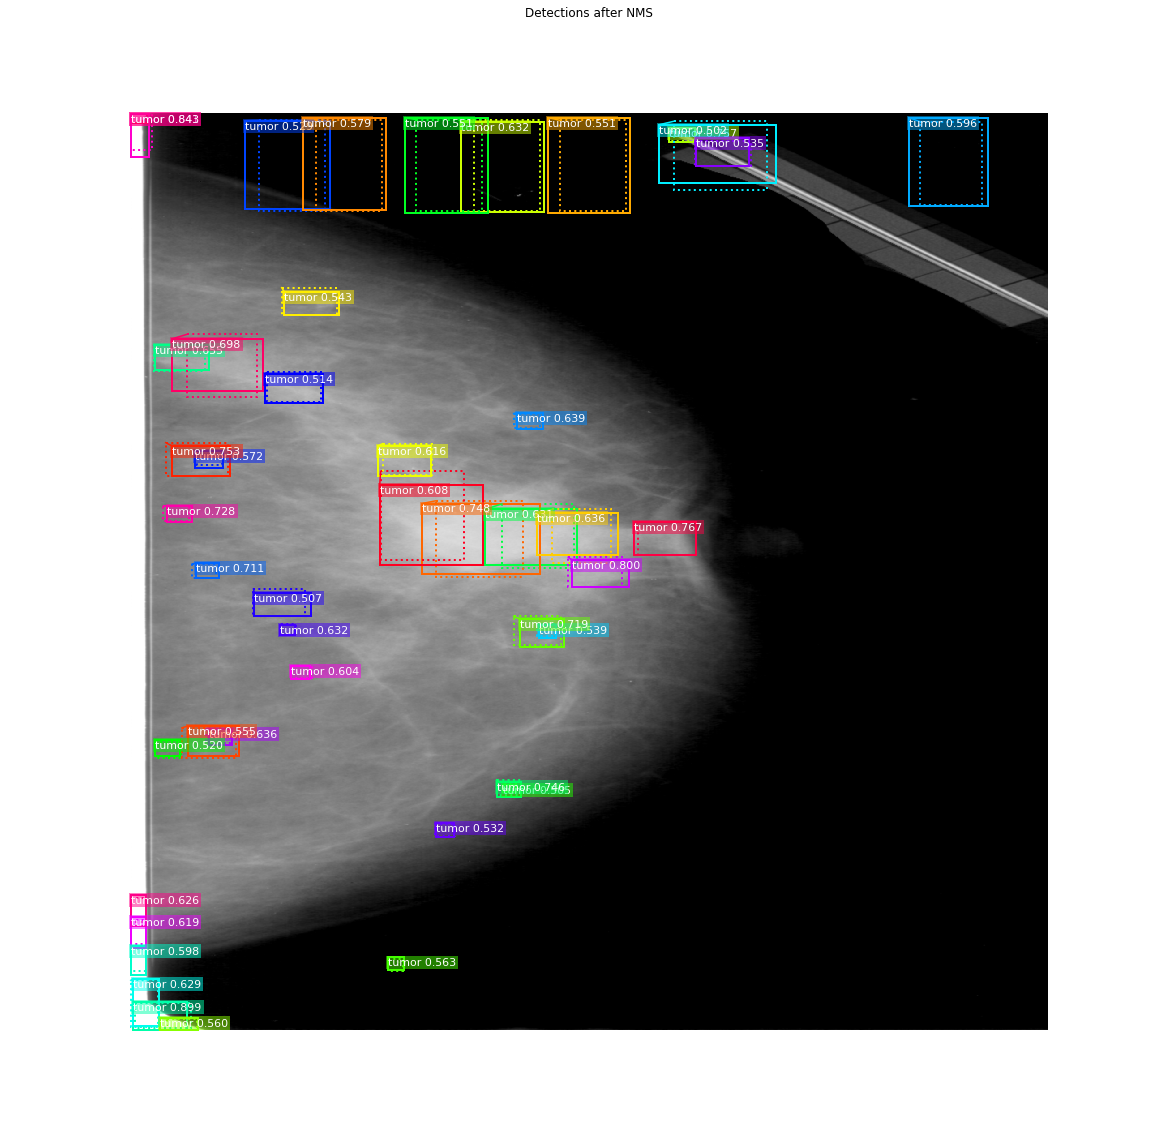

In [48]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image,
    boxes=utils.denorm_boxes(proposals[keep][ixs], image.shape[:2]),
    refined_boxes=utils.denorm_boxes(refined_proposals[keep][ixs], image.shape[:2]),
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

(1, 2048, 2048)


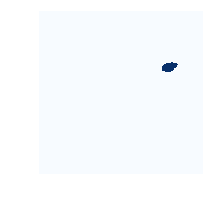

In [20]:
limit = 8
print(np.transpose(gt_mask[..., :limit], [2, 0, 1]).shape)
display_images(np.transpose(gt_mask[..., :limit], [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [21]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 400, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 400, 28, 28, 2)   min:    0.00756  max:    0.99846  float32
66 detections: ['tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor']


In [22]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (66, 28, 28)          min:    0.00756  max:    0.99846  float32
det_masks                shape: (66, 2048, 2048)      min:    0.00000  max:    1.00000  bool


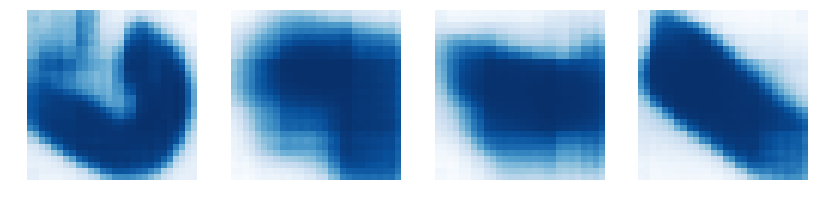

In [23]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

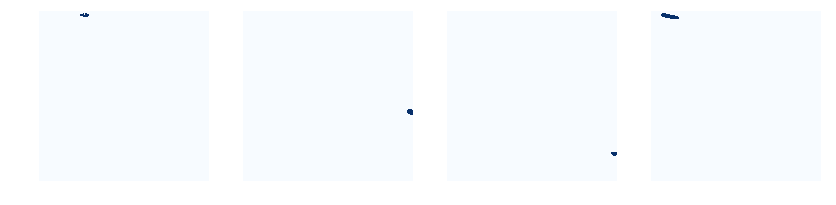

In [24]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [78]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 4096, 4096, 3)    min:  -54.78000  max:  200.22000  float32
res2c_out                shape: (1, 1024, 1024, 256)  min:    0.00000  max:   17.99281  float32
res3c_out                shape: (1, 512, 512, 512)    min:    0.00000  max:   30.18103  float32
rpn_bbox                 shape: (1, 4190208, 4)       min:  -11.33318  max:   30.77087  float32
roi                      shape: (1, 2000, 4)          min:    0.00000  max:    1.00000  float32


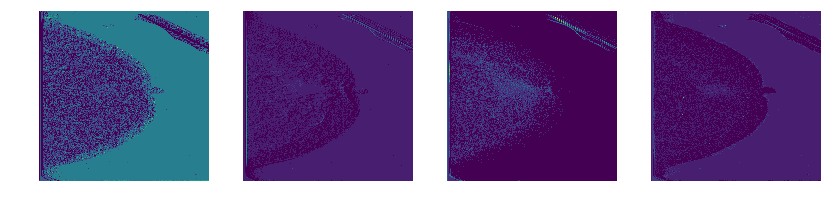

In [79]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)